# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="postnauka_batches", 
                                       batch_size=100)

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path="postnauka_batches", data_format='batches')

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [6]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(dictionary=batch_vectorizer.dictionary, 
                       num_topics=T, 
                       topic_names=topic_names, 
                       class_ids={"text":1, "author":1},
                       seed=-1,
                       cache_theta=True,
                       num_document_passes=5)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=1e5,
                                                            dictionary=batch_vectorizer.dictionary,
                                                            class_ids='text',
                                                            topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print word,
    print

sbj0:  быть что это этот который как век свой власть они его тот весь один все
sbj1:  быть что планета это земля этот который мочь очень они как звезда система такой атмосфера
sbj2:  система этот который быть что это такой время для как один или другой они если
sbj3:  как наука культура это рассказывать что какой понятие который этот кандидат или человек мир другой
sbj4:  право что этот быть это который такой как вещь тот если или мочь свой для
sbj5:  материал быть это этот что структура который как для такой мочь очень можно свойство свет
sbj6:  что это быть который этот она как фильм они текст книга литература очень мочь тот
sbj7:  быть что который этот человек они это как год его тот или свой смерть такой
sbj8:  это который этот быть метод какой как что химический новый рассказывать соединение наука реакция при
sbj9:  быть частица что это этот который квантовый теория взаимодействие физика как они весь поле кварк
sbj10:  быть год это что который война россия этот русский они как пер

In [11]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi2', 
                                                            tau=-1e5,
                                                            dictionary=batch_vectorizer.dictionary,
                                                            class_ids='text',
                                                            topic_names=["sbj"+str(i) for i in range(T-1)]))

Выполните еще 15 проходов по коллекции.

In [12]:
# Ваш код
#model_artm.regularizers['SparsePhi2'].topic_names = "sbj"
#model_artm.regularizers['SparsePhi'].tau = 1e5
#model_artm.regularizers['SparsePhi2'].tau = -1e5
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [14]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print word,
    print

sbj0:  быть что это этот который как свой век они власть его весь тот все один
sbj1:  быть что планета это земля этот который мочь очень они как такой атмосфера система жизнь
sbj2:  система этот который что это быть такой время для как один или другой они если
sbj3:  как наука рассказывать какой это культура понятие что кандидат доктор каков чем существовать современный когда
sbj4:  право что этот быть это который вещь такой как тот если или мочь римский свой
sbj5:  материал быть это этот что структура который для как можно мочь такой свет очень свойство
sbj6:  что это быть который этот она как фильм они литература текст книга очень тот мочь
sbj7:  быть что который этот это человек они как год его тот или свой смерть такой
sbj8:  это который этот быть что химический как новый соединение реакция метод вещество для при получать
sbj9:  быть частица что это этот который теория квантовый взаимодействие физика как весь они кварк такой
sbj10:  быть год это что который война россия этот русски

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [ ]:
sbj_topic_labels = []   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
Theta = model_artm.get_theta()
phi = model_artm.get_phi()

In [17]:
Theta.ix[0:10, 0:10]

,http://postnauka.ru/video/9561,http://postnauka.ru/video/9563,http://postnauka.ru/video/9690,http://postnauka.ru/video/9692,http://postnauka.ru/video/9727,http://postnauka.ru/video/9728,http://postnauka.ru/video/9729,http://postnauka.ru/video/9835,http://postnauka.ru/video/9854,http://postnauka.ru/video/9855
sbj0,0.002322,0.013662,0.000089,0.000043,0.000014,0.000824,0.000488,0.000087,0.000094,0.000197
sbj1,0.000289,0.015190,0.468156,0.000118,0.000087,0.000066,0.000014,0.719221,0.000586,0.000065
sbj2,0.001191,0.015097,0.002401,0.019632,0.000187,0.001202,0.000630,0.001421,0.006858,0.001429
sbj3,0.199544,0.022918,0.335464,0.306338,0.304005,0.525542,0.329397,0.160587,0.292934,0.329306
sbj4,0.155398,0.005111,0.003972,0.008821,0.000070,0.001986,0.000205,0.001750,0.000779,0.094481
sbj5,0.000259,0.007019,0.004820,0.000605,0.001387,0.000413,0.000044,0.001696,0.000322,0.000209
sbj6,0.000035,0.001884,0.001121,0.000452,0.000168,0.004127,0.000183,0.000111,0.000019,0.292820
sbj7,0.032779,0.004893,0.013279,0.000004,0.000002,0.004403,0.002417,0.000510,0.000189,0.000533
sbj8,0.003806,0.239126,0.038390,0.011462,0.004278,0.000756,0.000088,0.051226,0.005504,0.000057
sbj9,0.000580,0.002675,0.006032,0.000988,0.000093,0.000792,0.006671,0.001663,0.000300,0.000002


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

C:\Program Files\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


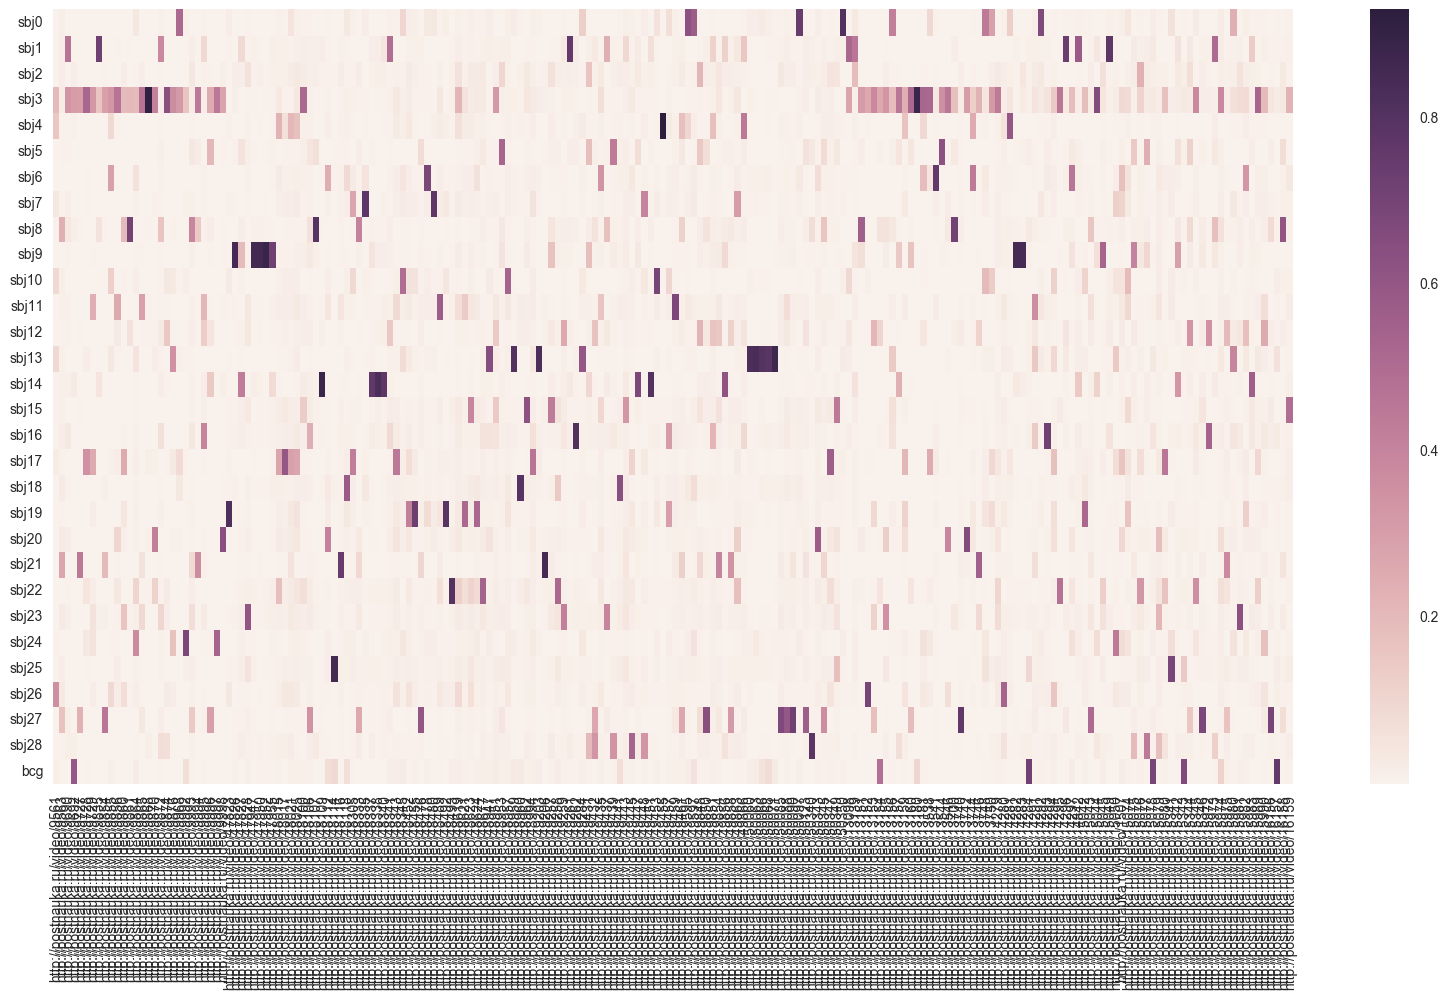

In [18]:
# Ваш кодseabo
plt.figure(figsize=(20,10))
seaborn.heatmap(Theta.ix[0:100, 0:200])


Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [19]:
# Ваш код
Theta.mean(axis=1) * 100

sbj0      2.923649
sbj1      3.354679
sbj2      2.457314
sbj3     10.185843
sbj4      2.419935
sbj5      3.416418
sbj6      2.512306
sbj7      2.057241
sbj8      3.787287
sbj9      4.433802
sbj10     3.054224
sbj11     2.828658
sbj12     3.560803
sbj13     3.116085
sbj14     4.191941
sbj15     3.026918
sbj16     2.445211
sbj17     3.556694
sbj18     2.191726
sbj19     2.061401
sbj20     3.432210
sbj21     2.930163
sbj22     3.267776
sbj23     2.771694
sbj24     2.986652
sbj25     1.829054
sbj26     3.683780
sbj27     5.487661
sbj28     2.559172
bcg       3.469708
dtype: float32

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

In [20]:
# Ваш код
phi_authors = model_artm.get_phi(class_ids=["author"])

In [21]:
phi_authors.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.0,0.0,3.497578e-15,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.000000,1.427091e-16,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
Сергей_Демокритов,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.031354,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.006366,0.0
Руслан_Смелянский,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,2.628331e-11,0.000000,...,0.053045,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
Александр_Апт,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,4.197786e-02,0.000000,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000009,0.000000,0.0
Людмила_Новикова,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


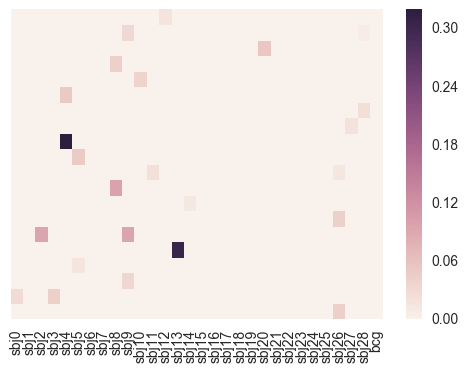

In [22]:
seaborn.heatmap(phi_authors[0:20], yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [23]:
phi_authors['mean'] = [x for x in phi_authors.mean(axis=1)]

Большинство авторов значимы в 1 теме, что логично.

In [24]:
phi_authors[phi_authors['mean'] > 0.01]

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg,mean
Дмитрий_Дождев,0.0,0.000000,0.0,0.000000,0.320027,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.010668
Алексей_Муравьёв,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.010178
Виктор_Вахштайн,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.564464,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.018815
Гасан_Гусейнов,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.329104,0.0,0.0,0.0,0.0,0.0,0.010970
Сергей_Попов,0.0,0.193506,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.011861
Станислав_Дробышевский,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.021278
Мария_Фаликман,0.0,0.000000,0.0,0.000033,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.010118


##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [25]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [26]:
phi_authors = phi_authors.drop('mean', axis=1)

In [30]:
# Ваш код
dists = pairwise_distances(phi_authors, metric="cosine")
mds_model_cos = MDS(random_state=321, n_components=2, dissimilarity="precomputed")
MDS_transformed_cos = mds_model_cos.fit_transform(dists.astype(np.float64))

Визуализируйте найденные двумерные представления с помощью функции scatter. 

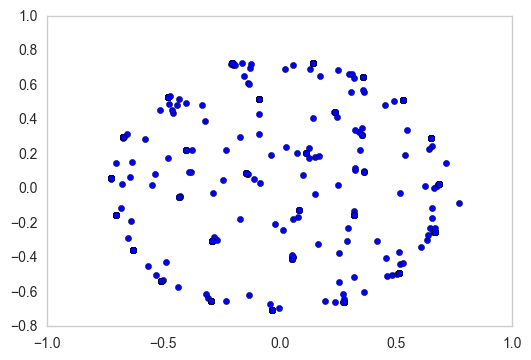

In [31]:
# Ваш код
plt.scatter(MDS_transformed_cos[:,0], MDS_transformed_cos[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

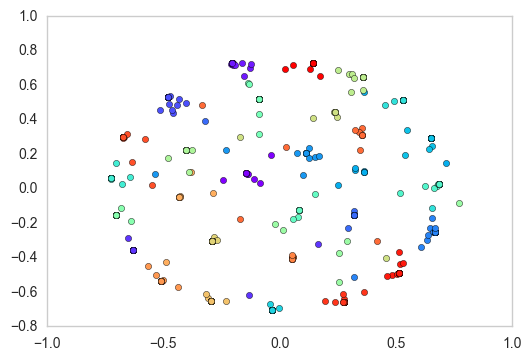

In [32]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
max_indexes = phi_authors.idxmax(axis=1)

# Ваш код
for i in range(len(MDS_transformed_cos)):
    #print max_indexes[i]
    plt.scatter(MDS_transformed_cos[i,0], 
                MDS_transformed_cos[i,1], 
                c = colors[int(max_indexes[i].replace('sbj', '').replace('bcg', '29'))])

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [43]:
# Ваш код
pdt = Theta

for i in range(0, Theta.shape[0]):
    for j in range(0, Theta.shape[1]):
        pdt.ix[i, j] = Theta.ix[i, j] / Theta.ix[i].sum()

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [44]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [45]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [58]:
# Ваш код
for i in range(0, 30):
    print Theta2.ix[i].argmax()

http://postnauka.ru/video/3406
http://postnauka.ru/video/32889
http://postnauka.ru/video/43679
http://postnauka.ru/video/3405
http://postnauka.ru/video/31688
http://postnauka.ru/video/31682
http://postnauka.ru/video/42807
http://postnauka.ru/video/32882
http://postnauka.ru/video/3389
http://postnauka.ru/video/33765
http://postnauka.ru/video/32637
http://postnauka.ru/video/31220
http://postnauka.ru/video/33771
http://postnauka.ru/video/3387
http://postnauka.ru/video/33755
http://postnauka.ru/video/33779
http://postnauka.ru/video/32898
http://postnauka.ru/video/32906
http://postnauka.ru/video/43684
http://postnauka.ru/video/43843
http://postnauka.ru/video/32900
http://postnauka.ru/video/32886
http://postnauka.ru/video/32901
http://postnauka.ru/video/3388
http://postnauka.ru/video/31580
http://postnauka.ru/video/40001
http://postnauka.ru/video/33941
http://postnauka.ru/video/3390
http://postnauka.ru/video/42800
http://postnauka.ru/video/3403


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 